In [1]:
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from pathlib import Path
import os
import pdb
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import random
from glob import glob
from tqdm import tqdm
from docai_util import is_color_image, binarize
from table_datasets import read_pascal_voc
from src.main import get_class_map
from docai_util import bboxes_to_cells
from collections import defaultdict

class_map = get_class_map('structure')
index_to_class_map = {val: key for key, val in class_map.items()}

color_map = {
    'table': (0, 0, 0),
    'table column': (255, 0, 0),
    'table row': (0, 255, 0),
    'table column header': (0, 0, 255),
    'table projected row header': (255, 255, 0),
    'table spanning cell': (255, 0, 255)
}

In [ ]:
def row_line_exists(image: np.ndarray, line_rate_threshold=0.8):
    assert image.dtype == np.uint8 or image.max() > 2

    bin_image = binarize(image)
    h, w = bin_image.shape

    # check line if exists
    row_sum = bin_image.sum(axis=1)
    row_lines = (row_sum >= int(w * line_rate_threshold)).astype(np.uint8)
    return np.any(row_lines)

In [ ]:
image_root = '/home/suqi/dataset/pubtables-1m/PubTables-1M-Structure/images'

# color_filtered = []
# line_filtered = []
# filtered = {}
# 
# for image_name in tqdm(sorted(os.listdir(image_root))[:10]):
#     image = np.array(Image.open(os.path.join(image_root, image_name)).convert('RGB'))
#     if is_color_image(image):
#         color_filtered.append(image)
#         print(f'Color image found: {image_name}')
#     if not row_line_exists(image):
#         line_filtered.append(image)
#         print(f'No line image found: {image_name}')
# 
# filtered['color'] = color_filtered
# filtered['line'] = line_filtered
# torch.save(filtered, '../statistics/filtered.pth')

In [2]:
union = torch.load('../statistics/filtered.pth')

In [3]:
print(len(union['color']))      # 101511
print(len(union['line']))       # 113311

101511
113311


In [ ]:
losses = torch.load('../statistics/losses_mini.pth')

In [ ]:
image_names, bbox_losses, giou_losses = [], [], []
for key, val in losses.items():
    image_names.append(key)
    bbox_losses.append(val['loss_bbox'])
    giou_losses.append(val['loss_giou'])

image_names, bbox_losses, giou_losses = map(np.array, (image_names, bbox_losses, giou_losses))
losses = bbox_losses + giou_losses
indices = np.argsort(losses)
sorted_image_names, sorted_losses = image_names[indices], losses[indices]

In [ ]:
plt.hist(sorted_losses, bins=np.linspace(0, 0.475, 100))
plt.title('losses')
plt.show()

plt.hist(sorted_losses[:-80000], bins=np.linspace(0, 0.475, 100))
plt.title('losses')
plt.show()


In [ ]:
del_images = sorted_image_names[-80000:]
del_images_filtered = []
for del_name in del_images:
    if '_COL_' in del_name or '_CELL_' in del_name:
        continue
    del_images_filtered.append(del_name)

print(len(del_images_filtered))     # 35769
print(len(union['color']))          # 101511
print(len(union['line']))           # 113311

print(len(set(del_images_filtered) & set(union['color'])))
print(len(set(del_images_filtered) & set(union['line'])))

image_names_set = set(image_names)
image_names_list = list(image_names)

color_image_indices, line_image_indices = [], []
for image_name in tqdm(union['color']):
    if image_name in image_names_set:
        color_image_indices.append(image_names_list.index(image_name))
        
for image_name in tqdm(union['line']):
    if image_name in image_names_set:
        line_image_indices.append(image_names_list.index(image_name))


In [ ]:
color_image_indices = np.array(color_image_indices)
line_image_indices = np.array(line_image_indices)
color_image_losses = losses[color_image_indices]
line_image_losses = losses[line_image_indices]

color_image_indices = color_image_indices[color_image_losses.argsort()[-10000: ]]
line_image_indices = line_image_indices[line_image_losses.argsort()[-10000: ]]

del_images_color = image_names[color_image_indices]
del_images_line = image_names[line_image_indices]

print(len(del_images_filtered)) # 35769
print(len(del_images_color))    # 10000
print(len(del_images_line))     # 10000

del_images_union = set(del_images_filtered) | set(del_images_color) | set(del_images_line)
print(len(del_images_union))    # 45535
with open(os.path.join('../statistics/filtered_images.txt'), 'w') as f:
    for name in del_images_union:
        f.write(f'{name}\n')

## 删除数据集中的需要过滤掉的数据

In [7]:
data_root = '/home/suqi/dataset/pubtables-1m/PubTables-1M-Structure'
target_root = '/home/suqi/dataset/pubtables-1m/PubTables-1M-Structure-Clean'
os.makedirs(target_root, exist_ok=True)

with open(os.path.join('../statistics/filtered_images.txt'), 'r') as f:
    del_images_union = set([line.strip() for line in f.readlines()])

for dir_name in ['images', 'train', 'val', 'test']:
    dir_path = os.path.join(data_root, dir_name)
    os.makedirs(os.path.join(target_root, dir_name), exist_ok=True)
    del_count = 0
    for name in tqdm(os.listdir(dir_path)):
        if '_COL_' in name:
            base_name = name.split('_COL_')[0]
        elif '_CELL_' in name:
            base_name = name.split('_CELL_')[0]
        else:
            base_name = name.split('.')[0]

        if (base_name + '.jpg') in del_images_union:
            del_count += 1
        else:
            os.link(os.path.join(dir_path, name), os.path.join(target_root, dir_name, name))

    print(del_count)

100%|██████████| 947642/947642 [00:16<00:00, 56489.80it/s]


45535


100%|██████████| 758849/758849 [00:14<00:00, 53271.71it/s]


40341


100%|██████████| 94959/94959 [00:04<00:00, 18999.63it/s]


5194


100%|██████████| 93834/93834 [00:01<00:00, 54558.96it/s]

0


In [8]:
for dir_name in ['images', 'train', 'val', 'test']:
    dir_path = os.path.join(target_root, dir_name)
    with open(os.path.join(target_root, f'{dir_name}_filelist.txt'), 'w') as f:
        for name in sorted(os.listdir(dir_path)):
            f.write(f'{dir_name}/{name}\n')

In [ ]:
image_root_pub = '/home/suqi/dataset/pubtables-1m/PubTables-1M-Structure/'
image_root_fin = '/home/suqi/dataset/FinTabNet.c/FinTabNet.c-Structure/'
os.makedirs('../debug/clean_dataset', exist_ok=True)

checkpoint = [0, 500, 1000, 2000, 4000, 10000, 20000, 50000, 100000]

# chosen_names = []
# for cp in checkpoint:
#     for j in range(100):
#         chosen_names.append([cp + j + 1, sorted_image_names[-(cp + j + 1)]])
chosen_names = [(0, 'PMC3240581_table_0.jpg')]

for idx, image_name in tqdm(chosen_names):
    if 'CELL' in image_name or 'COL' in image_name:
        continue
    base_name = image_name.split('.jpg')[0]
    image_root = glob(os.path.join(image_root_pub, 'images', image_name)) + glob(os.path.join(image_root_fin, 'images', image_name))
    label_root = (glob(os.path.join(image_root_pub, '**', f'{base_name}.xml'), recursive=True) + 
                  glob(os.path.join(image_root_fin, '**', f'{base_name}.xml'), recursive=True))
    assert len(image_root) == 1 and len(label_root) == 1
    
    image = np.array(Image.open(image_root[0]).convert('RGB'))
    plt.imshow(image)
    plt.show()
    # bboxes, labels = read_pascal_voc(label_root[0], class_map)
    # cells = bboxes_to_cells(np.array(bboxes), np.array(labels))
    # cell_image = image.copy()
    # for j, bbox in enumerate(cells):
    #     bbox = list(map(lambda x: int(x), bbox))
    #     x_min, y_min, x_max, y_max = bbox
    #     cell_image = cv2.rectangle(cell_image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=1)
    # 
    # image = np.concatenate([image, cell_image], axis=0)
    # Image.fromarray(image).save(f"../debug/clean_dataset/{str(idx).rjust(6, '0')}_{image_name}")

100%|██████████| 771927/771927 [00:00<00:00, 947387.70it/s]


1.7493303419675028


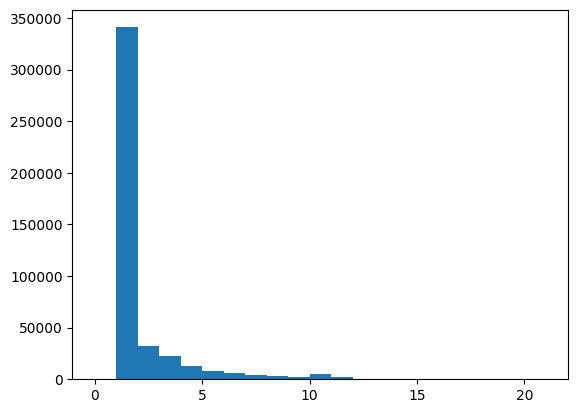

In [9]:
data_root_dirty = ""
data_root_clean = "/home/suqi/dataset/Pub_Fin_Syn_Union_Clean/images"

counter = defaultdict(lambda: 0)
for name in tqdm(sorted(os.listdir(data_root_clean))):
    if '_COL_' in name:
        name = name.split('_COL_')[0]
    elif '_CELL_' in name:
        name = name.split('_CELL_')[0]
    else:
        name = name.split('.jpg')[0]
    counter[name] += 1

counter = np.array(list(counter.values()))
assert sum(counter) == len(os.listdir(data_root_clean))
print(np.mean(counter))

plt.hist(counter, bins=range(0, 22))
plt.show()